# Met stations

In [1]:
import os
from datetime import datetime, timezone
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pooch
from matplotlib import ticker
import climag.plot_configs as cplt

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-02-22 12:49:38.093180+00:00


## Met Éireann stations

- Station details can be found here:
  <https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv>
- <https://www.met.ie/climate/weather-observing-stations>
- Check the "Show closed stations" box to obtain data for this replaced
  station: <https://www.met.ie/climate/available-data/historical-data>

In [4]:
URL = "https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv"
SUB_DIR = os.path.join("data", "met", "MetEireann")
KNOWN_HASH = None
os.makedirs(SUB_DIR, exist_ok=True)
FILE_NAME = "StationDetails.csv"

In [5]:
# download data if necessary
if not os.path.isfile(os.path.join(SUB_DIR, FILE_NAME)):
    pooch.retrieve(
        url=URL, known_hash=KNOWN_HASH, fname=FILE_NAME, path=SUB_DIR
    )

    with open(
        os.path.join(SUB_DIR, f"{FILE_NAME[:-4]}.txt"), "w", encoding="utf-8"
    ) as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

In [6]:
stations_roi = pd.read_csv(os.path.join(SUB_DIR, FILE_NAME))

In [7]:
stations_roi.shape

(2083, 10)

In [8]:
stations_roi.head()

,county,station name,name,height(m),easting,northing,latitude,longitude,open year,close year
0,Antrim,5880,LH_RATHLIN_WEST,10,309200,451800,55.30083,-6.28028,2000,(null)
1,Carlow,4415,TULLOW (Waterworks),76,284700,173400,52.80528,-6.74306,1985,(null)
2,Carlow,2414,BORRIS G.S.,85,272400,150700,52.60278,-6.93056,1944,1991
3,Carlow,1214,CARLOW (SUGAR FACTORY),58,272200,178400,52.85139,-6.92778,1953,1960
4,Carlow,115,HACKETSTOWN RECTORY,182,297600,180500,52.86667,-6.55000,1910,1944


In [9]:
# convert coordinates to well known text
stations_roi["wkt"] = (
    "POINT ("
    + stations_roi["longitude"].astype(str)
    + " "
    + stations_roi["latitude"].astype(str)
    + ")"
)

In [10]:
# convert wkt to geometry
stations_roi = gpd.GeoDataFrame(
    stations_roi,
    geometry=gpd.GeoSeries.from_wkt(stations_roi["wkt"]),
    crs="EPSG:4326",
)

In [11]:
# drop wkt, lon, lat column
stations_roi.drop(columns=["wkt", "longitude", "latitude"], inplace=True)

In [13]:
# replace null values
stations_roi = stations_roi.replace(
    {"close year": {"(null)": np.nan}, "open year": {"(null)": np.nan}}
)

In [14]:
# stations_roi["close year"] = pd.to_numeric(stations_roi["close year"])
# stations_roi["open year"] = pd.to_numeric(stations_roi["open year"])

In [15]:
# # filter stations that have data for the historic reference period
# stations_roi = stations_roi[
#     (stations_roi["close year"] >= 2005) &
#     (stations_roi["open year"] <= 1976)
# ]

In [17]:
# # replace null values
# stations_roi = stations_roi.replace({"close year": {np.nan: None}})
# stations_roi = stations_roi.replace({"open year": {np.nan: None}})

In [15]:
stations_roi.head()

,county,station name,name,height(m),easting,northing,open year,close year,geometry
0,Antrim,5880,LH_RATHLIN_WEST,10,309200,451800,2000,NaN,POINT (-6.28028 55.30083)
1,Carlow,4415,TULLOW (Waterworks),76,284700,173400,1985,NaN,POINT (-6.74306 52.80528)
2,Carlow,2414,BORRIS G.S.,85,272400,150700,1944,1991,POINT (-6.93056 52.60278)
3,Carlow,1214,CARLOW (SUGAR FACTORY),58,272200,178400,1953,1960,POINT (-6.92778 52.85139)
4,Carlow,115,HACKETSTOWN RECTORY,182,297600,180500,1910,1944,POINT (-6.55000 52.86667)


In [19]:
stations_roi.shape

(223, 9)

## Met Office data for stations in Northern Ireland

<https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-synoptic-and-climate-stations>

Met Office (2019): Met Office MIDAS Open: UK Land Surface Stations Data
(1853-current). Centre for Environmental Data Analysis.
<https://catalogue.ceda.ac.uk/uuid/dbd451271eb04662beade68da43546e1>

In [16]:
SUB_DIR = os.path.join("data", "met", "MetOffice")

In [19]:
stations_ni = pd.read_csv(
    os.path.join(
        SUB_DIR,
        "midas-open_uk-daily-weather-obs_dv-202107_station-metadata.csv",
    ),
    skiprows=46,
    skipfooter=1,
    engine="python",
)

In [20]:
stations_ni.shape

(1588, 9)

In [21]:
stations_ni.head()

,src_id,station_name,station_file_name,historic_county,station_latitude,station_longitude,station_elevation,first_year,last_year
0,1,FOULA,foula,shetland,60.154,-2.074,22,1985,2003
1,3,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020
2,4,SUMBURGH,sumburgh,shetland,59.879,-1.299,7,1978,1996
3,5,HAMNAVOE,hamnavoe,shetland,60.104,-1.333,21,1962,1972
4,7,COLLAFIRTH,collafirth,shetland,60.533,-1.391,228,1963,1991


In [22]:
# list of historic counties in NI
# https://en.wikipedia.org/wiki/Historic_counties_of_the_United_Kingdom
counties_ni = [
    "antrim",
    "armagh",
    "down",
    "fermanagh",
    "londonderry",
    "tyrone",
]

In [23]:
# keep only NI data
stations_ni = stations_ni[stations_ni["historic_county"].isin(counties_ni)]

In [24]:
# convert coordinates to well known text
stations_ni["wkt"] = (
    "POINT ("
    + stations_ni["station_longitude"].astype(str)
    + " "
    + stations_ni["station_latitude"].astype(str)
    + ")"
)

In [25]:
# convert wkt to geometry
stations_ni = gpd.GeoDataFrame(
    stations_ni,
    geometry=gpd.GeoSeries.from_wkt(stations_ni["wkt"]),
    crs="EPSG:4326",
)

In [26]:
# drop wkt, lon, lat column
stations_ni.drop(
    columns=["wkt", "station_longitude", "station_latitude"], inplace=True
)

In [31]:
# # filter stations that have data for the historic reference period
# stations_ni = stations_ni[
#     (stations_ni["last_year"] >= 2005) & (stations_ni["first_year"] <= 1976)
# ]

In [27]:
# rename Londonderry to Derry
stations_ni = stations_ni.replace(
    {"historic_county": {"londonderry": "derry"}}
)

In [28]:
stations_ni.head()

,src_id,station_name,station_file_name,historic_county,station_elevation,first_year,last_year,geometry
301,24924,"DOWNPATRICK, BALLYGALLUM",downpatrick-ballygallum,down,18,1999,2000,POINT (-5.68000 54.29400)
673,25353,PEATLANDS,peatlands,armagh,34,2000,2019,POINT (-6.62000 54.48300)
781,17292,PORTRUSH,portrush,antrim,8,1996,2002,POINT (-6.65600 55.20800)
830,17341,BALLYGAWLEY PRIMARY SCHOOL,ballygawley-primary-school,tyrone,88,1996,1998,POINT (-7.03500 54.46500)
1232,1425,COOLKEERAGH POWER STATION,coolkeeragh-power-station,derry,3,1971,1980,POINT (-7.25100 55.04300)


In [29]:
stations_ni.shape

(156, 8)

## Plot

In [31]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

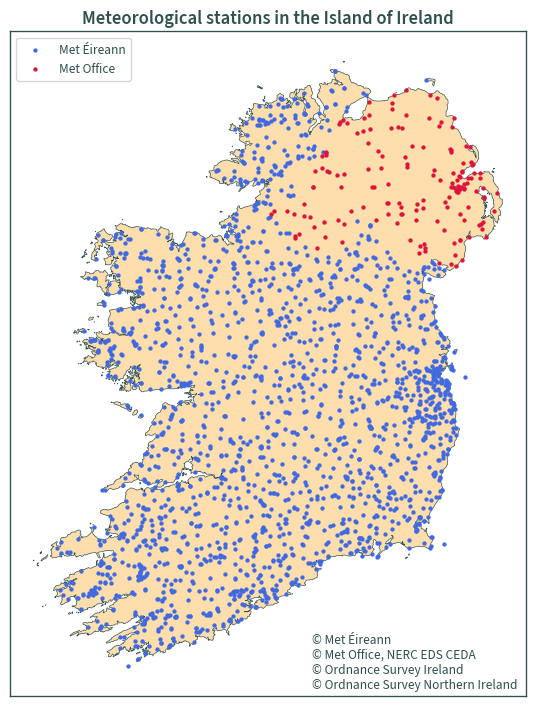

In [58]:
base = ie.plot(
    color="navajowhite",
    figsize=(9, 9),
    edgecolor="darkslategrey",
    linewidth=0.5,
)
stations_roi.to_crs(ie.crs).to_crs(ie.crs).plot(
    ax=base, color="royalblue", markersize=5, label="Met Éireann"
)
stations_ni.to_crs(ie.crs).plot(
    ax=base, color="crimson", markersize=5, label="Met Office"
)

# base.xaxis.set_major_formatter(cplt.longitude_tick_format)
# base.yaxis.set_major_formatter(cplt.latitude_tick_format)
# base.yaxis.set_major_locator(ticker.MultipleLocator(1))
base.tick_params(labelbottom=False, labelleft=False)

plt.title("Meteorological stations in the Island of Ireland")
plt.text(
    625000,
    500000,
    "© Met Éireann\n© Met Office, NERC EDS CEDA\n"
    + "© Ordnance Survey Ireland\n"
    "© Ordnance Survey Northern Ireland",
)
plt.legend(loc="upper left")

plt.show()

In [38]:
# save as GPKG
GPKG_MET = os.path.join("data", "met", "met_stations.gpkg")
stations_roi.to_file(GPKG_MET, layer="MetEireann")
stations_ni.to_file(GPKG_MET, layer="MetOffice")